In [1]:
import numpy as np

np.random.seed(10)

# Reading the corpus 

In [2]:
import rarfile
import re

corpus = []

with rarfile.RarFile("./data/corpus.rar") as rar_corpus:
    for file in rar_corpus.infolist():
        if file.is_file():
            with rar_corpus.open(file) as doc:
                doc_class, doc_name = re.search(
                    r"training\/(.*)\/(.*)", file.filename
                ).groups()
                doc_content = doc.read().decode("utf-8")
                corpus.append((doc_class, doc_content))

# Building the dataset

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

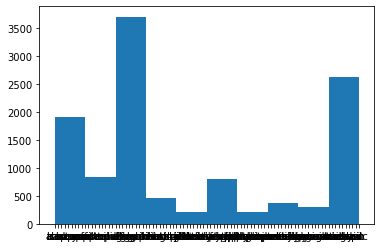

In [29]:
docs = [doc for _, doc in corpus]
classes = [doc_class for doc_class, _ in corpus]

plt.hist(classes)
plt.show()

In [5]:
df = pd.DataFrame({"docs": docs, "classes": classes})
df

,docs,classes
0,\n\r\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLET...,acq
1,\n\r\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST Q...,acq
2,\n\r\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRA...,acq
3,\n\r\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHE...,acq
4,\n\r\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED ...,acq
...,...,...
11408,\n\r\nPEGASUS GOLD <PGULF> STARTS MILLING IN M...,zinc
11409,"\n\r\nWORLD ZINC STOCKS FALL 7,700 TONNES IN F...",zinc
11410,\n\r\nLME DETAILS MARCH 1987 TURNOVER\r\n\n ...,zinc
11411,\n\r\nBALL <BLL> TO SUPPLY PENNY BLANKS TO MIN...,zinc


Drop duplicates

In [6]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

160


In [7]:
docs = df["docs"].values
classes = df["classes"].values

Remove documents that their classes have less than 5 samples

In [8]:
class_counts = {}
for doc_class in classes:
    if doc_class not in class_counts:
        class_counts[doc_class] = 0
    class_counts[doc_class] += 1

low_class_counts = [doc_class for doc_class, count in class_counts.items() if count < 5]
low_class_counts_indices = [
    idx for idx, doc_class in enumerate(classes) if doc_class in low_class_counts
]

docs = [doc for idx, doc in enumerate(docs) if idx not in low_class_counts_indices]
classes = [
    doc_class
    for idx, doc_class in enumerate(classes)
    if idx not in low_class_counts_indices
]

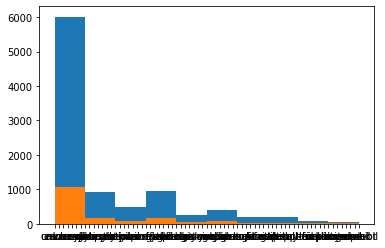

In [9]:
train_docs, test_docs, train_classes, test_classes = train_test_split(
    docs, classes, test_size=0.15, stratify=classes
)

plt.hist(train_classes)
plt.hist(test_classes)
plt.show()

# Feature extraction and selection from corpus

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
import nltk

nltk.download("stopwords")

treebank_word_tokenizer = TreebankWordTokenizer()
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/obadakhalili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def tokenize_normalize(
    tokenize=treebank_word_tokenizer.tokenize,
    normalize=porter_stemmer.stem,
    stopwords=nltk.corpus.stopwords.words("english"),
):
    return lambda doc: [
        normalize(token)
        for token in tokenize(doc)
        if len(token) > 1 and token not in stopwords
    ]


feature_extraction_steps = [
    TfidfVectorizer(tokenizer=tokenize_normalize(), sublinear_tf=True),
    TruncatedSVD(n_components=500),
]

# Training

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from tensorflow import keras

2022-04-22 20:46:59.757188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 20:46:59.757224: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Random Forest

In [13]:
randomforest_gscv = GridSearchCV(
    make_pipeline(
        *feature_extraction_steps,
        RandomForestClassifier(),
    ),
    param_grid={
        "tfidfvectorizer__sublinear_tf": [True, False],
        "truncatedsvd__n_components": [50, 500],
        "randomforestclassifier__max_depth": [None, 100],
        "randomforestclassifier__min_samples_split": [10, 50],
        "randomforestclassifier__max_features": ["sqrt", "log2"],
        "randomforestclassifier__n_estimators": [100, 400],
    },
    # f1 score for multiclass classification where precision/recall are computed for each class then weight-averaged into one score
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
)
randomforest_gscv.fit(train_docs, train_classes)

print(
    f"Best parameter(s): {randomforest_gscv.best_params_}, with score {randomforest_gscv.best_score_}"
)

/home/obadakhalili/dev/NLP/text-classification/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameter(s): {'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 400, 'tfidfvectorizer__sublinear_tf': True, 'truncatedsvd__n_components': 50}, with score 0.6500751539906754


In [14]:
def print_classification_metrics(test_classes, predictions):
    for metric in [
        metrics.precision_score,
        metrics.recall_score,
        metrics.f1_score,
        metrics.accuracy_score,
    ]:
        score = (
            metric(test_classes, predictions)
            if metric == metrics.accuracy_score
            else metric(
                test_classes,
                predictions,
                average="weighted",
                zero_division=1,
            )
        )
        print(f"{metric.__name__}: {score}")

In [16]:
randomforest_classifier = randomforest_gscv.best_estimator_
print_classification_metrics(test_classes, randomforest_classifier.predict(test_docs))

precision_score: 0.6690607035543426
recall_score: 0.6682520808561236
f1_score: 0.6520409788639594
accuracy_score: 0.6682520808561236


## SVM

In [17]:
svm_gscv = GridSearchCV(
    make_pipeline(*feature_extraction_steps, LinearSVC()),
    param_grid={
        "tfidfvectorizer__sublinear_tf": [True, False],
        "truncatedsvd__n_components": [50, 500],
        "linearsvc__C": [0.1, 1, 10],
    },
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
)
svm_gscv.fit(train_docs, train_classes)

print(f"Best parameter(s): {svm_gscv.best_params_}, with score {svm_gscv.best_score_}")

Best parameter(s): {'linearsvc__C': 1, 'tfidfvectorizer__sublinear_tf': False, 'truncatedsvd__n_components': 500}, with score 0.72595771060772


In [18]:
svm_classifier = svm_gscv.best_estimator_
print_classification_metrics(test_classes, svm_classifier.predict(test_docs))

precision_score: 0.7376975597580621
recall_score: 0.7384066587395958
f1_score: 0.7281352538336796
accuracy_score: 0.7384066587395958


# AdaBoost

In [19]:
adaboost_gscv = GridSearchCV(
    make_pipeline(*feature_extraction_steps, AdaBoostClassifier()),
    param_grid={
        "tfidfvectorizer__sublinear_tf": [True, False],
        "truncatedsvd__n_components": [50, 500],
        "adaboostclassifier__n_estimators": [100, 400],
        "adaboostclassifier__learning_rate": [0.1, 0.5, 1],
    },
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
)
adaboost_gscv.fit(train_docs, train_classes)

print(
    f"Best parameter(s): {adaboost_gscv.best_params_}, with score {adaboost_gscv.best_score_}"
)

Best parameter(s): {'adaboostclassifier__learning_rate': 0.1, 'adaboostclassifier__n_estimators': 400, 'tfidfvectorizer__sublinear_tf': True, 'truncatedsvd__n_components': 50}, with score 0.4513310856286507


In [20]:
adaboost_classifier = adaboost_gscv.best_estimator_
print_classification_metrics(test_classes, adaboost_classifier.predict(test_docs))

precision_score: 0.6161580301571902
recall_score: 0.4982164090368609
f1_score: 0.47559483229664085
accuracy_score: 0.4982164090368609


## Naive Bayes

In [21]:
MNNB_gscv = GridSearchCV(
    make_pipeline(feature_extraction_steps[0], MultinomialNB()),
    param_grid={
        "tfidfvectorizer__sublinear_tf": [True, False],
    },
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
)
MNNB_gscv.fit(train_docs, train_classes)

print(
    f"Best parameter(s): {MNNB_gscv.best_params_}, with score {MNNB_gscv.best_score_}"
)

Best parameter(s): {'tfidfvectorizer__sublinear_tf': False}, with score 0.4373312621600521


In [22]:
MNNB = MNNB_gscv.best_estimator_
print_classification_metrics(test_classes, MNNB.predict(test_docs))

precision_score: 0.7473230591712232
recall_score: 0.5648038049940547
f1_score: 0.46694924677194377
accuracy_score: 0.5648038049940547


## FCNN

In [23]:
text_preprocessor = make_pipeline(
    *feature_extraction_steps,
)
text_preprocessor.fit([*train_docs, *test_docs])

train_vect_docs = text_preprocessor.transform(train_docs)
test_vect_docs = text_preprocessor.transform(test_docs)

In [24]:
classes_encoder = LabelEncoder()
classes_encoder.fit([*train_classes, *test_classes])

train_numerical_classes = classes_encoder.transform(train_classes)
test_numerical_classes = classes_encoder.transform(test_classes)

In [30]:
fcnn = keras.Sequential(
    [
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(len(classes_encoder.classes_), activation="softmax"),
    ]
)
fcnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [26]:
fcnn.fit(train_vect_docs, train_numerical_classes, epochs=10, batch_size=32)

Epoch 1/10
298/298 [==============================] - 1s 2ms/step - loss: 2.8968 - accuracy: 0.3855
Epoch 2/10
298/298 [==============================] - 1s 2ms/step - loss: 1.7289 - accuracy: 0.5989
Epoch 3/10
298/298 [==============================] - 1s 2ms/step - loss: 1.2955 - accuracy: 0.6909
Epoch 4/10
298/298 [==============================] - 1s 2ms/step - loss: 1.0678 - accuracy: 0.7287
Epoch 5/10
298/298 [==============================] - 1s 2ms/step - loss: 0.9269 - accuracy: 0.7457
Epoch 6/10
298/298 [==============================] - 1s 2ms/step - loss: 0.8298 - accuracy: 0.7586
Epoch 7/10
298/298 [==============================] - 1s 2ms/step - loss: 0.7538 - accuracy: 0.7659
Epoch 8/10
298/298 [==============================] - 1s 2ms/step - loss: 0.7016 - accuracy: 0.7748
Epoch 9/10
298/298 [==============================] - 1s 2ms/step - loss: 0.6612 - accuracy: 0.7759
Epoch 10/10
298/298 [==============================] - 1s 2ms/step - loss: 0.6239 - accuracy: 0.7841

In [27]:
print_classification_metrics(
    test_numerical_classes, fcnn.predict(test_vect_docs).argmax(axis=1)
)

precision_score: 0.7554004508678043
recall_score: 0.748513674197384
f1_score: 0.7281356964377464
accuracy_score: 0.748513674197384
